In [1]:
import numpy
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
# import pycountry
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import numba
import copy
import glob
from numba import njit
import pandas
import glob

In [2]:
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools

In [3]:
temperature = np.array(range(200, 300))
dpd = (np.array(range(0,500,5))/10)[:100]
p = np.array(range(0,1000,10))*100
lon = [18.0]
lat = [42.25]
time = pd.date_range("2014-09-06", periods=100)
reference_time = pd.Timestamp("2014-09-05")


In [4]:
ta_low_to_high = xarray.DataArray(
     data=temperature,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="K",
     ),
 )
ta_low_to_high

<xarray.DataArray (time: 100)>
array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        K

In [5]:
ta_high_to_low = xarray.DataArray(
     data=np.flip(temperature),
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="K",
     ),
 )
ta_high_to_low

<xarray.DataArray (time: 100)>
array([299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287,
       286, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274,
       273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261,
       260, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248,
       247, 246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235,
       234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222,
       221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209,
       208, 207, 206, 205, 204, 203, 202, 201, 200])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        K

In [6]:
dpd_low_to_high = xarray.DataArray(
     data=dpd,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="K",
     ),
 )
dpd_low_to_high

<xarray.DataArray (time: 100)>
array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        K

In [27]:
sh_low_to_high = xarray.DataArray(
     data=dpd,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="g/kg",
     ),
 )
sh_low_to_high

<xarray.DataArray (time: 100)>
array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        g/kg

In [8]:
p_low_to_high = xarray.DataArray(
     data=p,
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="Pa",
     ),
 )
p_low_to_high

<xarray.DataArray (time: 100)>
array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
       54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000,
       63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000,
       72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000,
       81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000,
       90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000,
       99000])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        Pa

In [9]:
p_high_to_low = xarray.DataArray(
     data=np.flip(p),
     dims=['time'],
     coords=dict(
         time=time,
         reference_time=reference_time,
     ),
     attrs=dict(
         description="temperature.",
         units="Pa",
     ),
 )
p_high_to_low

<xarray.DataArray (time: 100)>
array([99000, 98000, 97000, 96000, 95000, 94000, 93000, 92000, 91000,
       90000, 89000, 88000, 87000, 86000, 85000, 84000, 83000, 82000,
       81000, 80000, 79000, 78000, 77000, 76000, 75000, 74000, 73000,
       72000, 71000, 70000, 69000, 68000, 67000, 66000, 65000, 64000,
       63000, 62000, 61000, 60000, 59000, 58000, 57000, 56000, 55000,
       54000, 53000, 52000, 51000, 50000, 49000, 48000, 47000, 46000,
       45000, 44000, 43000, 42000, 41000, 40000, 39000, 38000, 37000,
       36000, 35000, 34000, 33000, 32000, 31000, 30000, 29000, 28000,
       27000, 26000, 25000, 24000, 23000, 22000, 21000, 20000, 19000,
       18000, 17000, 16000, 15000, 14000, 13000, 12000, 11000, 10000,
        9000,  8000,  7000,  6000,  5000,  4000,  3000,  2000,  1000,
           0])
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2014-12-14
    reference_time  datetime64[ns] 2014-09-05
Attributes:
    description:  temperature.
    units:        Pa

---

In [12]:
import matplotlib.pyplot as plt

<xarray.DataArray 'rh' (time: 100)>
array([1.      , 0.931037, 0.867819, 0.8098  , 0.756493, 0.707461,
       0.662311, 0.620691, 0.582285, 0.546807, 0.514001, 0.483636,
       0.455502, 0.429409, 0.405187, 0.382681, 0.36175 , 0.342265,
       0.324111, 0.307182, 0.291382, 0.276624, 0.262826, 0.249917,
       0.237828, 0.2265  , 0.215875, 0.205903, 0.196536, 0.187732,
       0.17945 , 0.171655, 0.164311, 0.157389, 0.150859, 0.144695,
       0.138874, 0.133372, 0.128168, 0.123244, 0.118581, 0.114163,
       0.109975, 0.106002, 0.102231, 0.098649, 0.095246, 0.092011,
       0.088934, 0.086005, 0.083216, 0.080559, 0.078026, 0.075611,
       0.073306, 0.071106, 0.069005, 0.066997, 0.065078, 0.063243,
       0.061487, 0.059807, 0.058197, 0.056656, 0.055178, 0.053762,
       0.052403, 0.051099, 0.049848, 0.048646, 0.047492, 0.046383,
       0.045317, 0.044292, 0.043305, 0.042356, 0.041443, 0.040563,
       0.039716, 0.038899, 0.038113, 0.037354, 0.036623, 0.035917,
       0.035236, 0.034579,

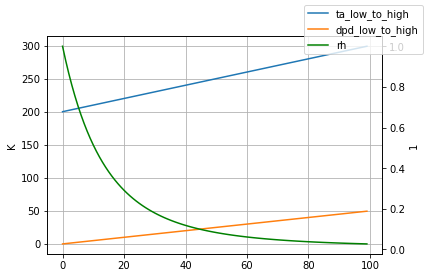

In [23]:
rh = rasotools.met.convert.to_rh(temp=ta_low_to_high, dpd=dpd_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_low_to_high, label='ta_low_to_high')
ax.plot(range(0,100), dpd_low_to_high, label='dpd_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

<xarray.DataArray 'rh' (time: 100)>
array([1.00000e+00, 9.70544e-01, 9.41416e-01, 9.12628e-01, 8.84193e-01,
       8.56121e-01, 8.28425e-01, 8.01117e-01, 7.74207e-01, 7.47707e-01,
       7.21626e-01, 6.95975e-01, 6.70764e-01, 6.46003e-01, 6.21699e-01,
       5.97861e-01, 5.74498e-01, 5.51617e-01, 5.29226e-01, 5.07329e-01,
       4.85934e-01, 4.65046e-01, 4.44669e-01, 4.24808e-01, 4.05466e-01,
       3.86647e-01, 3.68352e-01, 3.50583e-01, 3.33342e-01, 3.16628e-01,
       3.00442e-01, 2.84782e-01, 2.69647e-01, 2.55034e-01, 2.40941e-01,
       2.27364e-01, 2.14299e-01, 2.01740e-01, 1.89683e-01, 1.78121e-01,
       1.67048e-01, 1.56455e-01, 1.46336e-01, 1.36682e-01, 1.27483e-01,
       1.18731e-01, 1.10415e-01, 1.02525e-01, 9.50510e-02, 8.79800e-02,
       8.13030e-02, 7.50070e-02, 6.90790e-02, 6.35080e-02, 5.82810e-02,
       5.33850e-02, 4.88080e-02, 4.45370e-02, 4.05590e-02, 3.68610e-02,
       3.34300e-02, 3.02530e-02, 2.73180e-02, 2.46120e-02, 2.21230e-02,
       1.98380e-02, 1.77460e

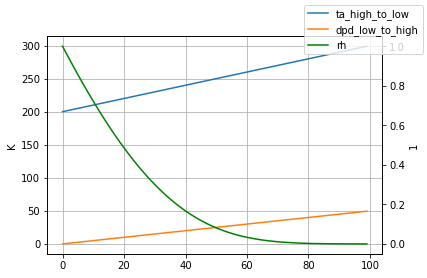

In [24]:
rh = rasotools.met.convert.to_rh(temp=ta_high_to_low, dpd=dpd_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_low_to_high, label='ta_high_to_low')
ax.plot(range(0,100), dpd_low_to_high, label='dpd_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

Warning relative humidiy outside of normal range
<xarray.DataArray 'rh' (time: 100)>
array([    0.      ,  1603.803739,  4514.860581,  7425.232993,
        9913.527434, 11873.256405, 13318.099141, 14306.09313 ,
       14907.897705, 15193.229859, 15225.329516, 15059.109963,
       14741.009288, 14309.596426, 13796.469606, 13227.221022,
       12622.36024 , 11998.149585, 11367.33581 , 10739.778009,
       10122.979121,  9522.531433,  8942.48726 ,  8385.665574,
        7853.904424,  7348.267847,  6869.214815,  6416.736642,
        5990.468323,  5589.778361,  5213.840917,  4861.693471,
        4532.282615,  4224.50019 ,  3937.211533,  3669.27736 ,
        3419.570468,  3186.98828 ,  2970.46205 ,  2768.963395,
        2581.508702,  2407.161865,  2245.035702,  2094.292363,
        1954.142948,  1823.846548,  1702.708841,  1590.080389,
        1485.354716,  1387.966254,  1297.388215,  1213.130438,
        1134.737247,  1061.785342,   993.881757,   930.661878,
         871.787559,   816.945316

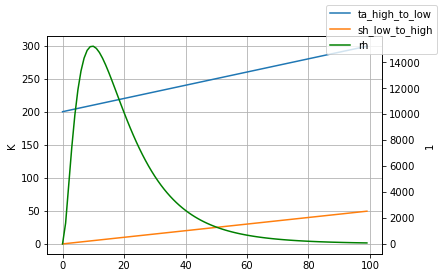

In [32]:
rh = rasotools.met.convert.to_rh(temp=ta_low_to_high, press=p_low_to_high, spec_humi=sh_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_low_to_high, label='ta_high_to_low')
ax.plot(range(0,100), sh_low_to_high, label='sh_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

Warning relative humidiy outside of normal range
<xarray.DataArray 'rh' (time: 100)>
array([0.00000000e+00, 1.96140000e-01, 6.75536000e-01, 1.35784900e+00,
       2.21342900e+00, 3.23350600e+00, 4.41971900e+00, 5.77983500e+00,
       7.32583700e+00, 9.07304400e+00, 1.10397220e+01, 1.32469700e+01,
       1.57187560e+01, 1.84820640e+01, 2.15671150e+01, 2.50076470e+01,
       2.88412650e+01, 3.31098290e+01, 3.78599240e+01, 4.31433680e+01,
       4.90178110e+01, 5.55473880e+01, 6.28034760e+01, 7.08655250e+01,
       7.98220120e+01, 8.97714990e+01, 1.00823833e+02, 1.13101494e+02,
       1.26741111e+02, 1.41895179e+02, 1.58733980e+02, 1.77447769e+02,
       1.98249227e+02, 2.21376239e+02, 2.47095034e+02, 2.75703741e+02,
       3.07536404e+02, 3.42967548e+02, 3.82417335e+02, 4.26357434e+02,
       4.75317674e+02, 5.29893609e+02, 5.90755120e+02, 6.58656207e+02,
       7.34446135e+02, 8.19082158e+02, 9.13644011e+02, 1.01935048e+03,
       1.13757832e+03, 1.26988393e+03, 1.41802807e+03, 1.584004

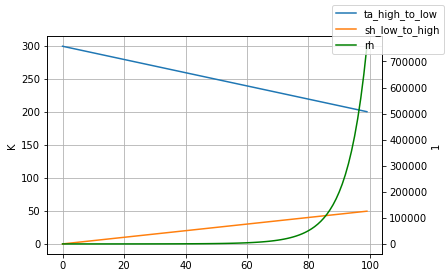

In [34]:
rh = rasotools.met.convert.to_rh(temp=ta_high_to_low, press=p_low_to_high, spec_humi=sh_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_high_to_low, label='ta_high_to_low')
ax.plot(range(0,100), sh_low_to_high, label='sh_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

Warning relative humidiy outside of normal range
<xarray.DataArray 'rh' (time: 100)>
array([0.00000000e+00, 1.91574550e+01, 3.26562550e+01, 4.33119080e+01,
       5.24040690e+01, 6.06034560e+01, 6.83002340e+01, 7.57409960e+01,
       8.30930020e+01, 9.04771240e+01, 9.79859720e+01, 1.05694470e+02,
       1.13666342e+02, 1.21958273e+02, 1.30622687e+02, 1.39709689e+02,
       1.49268459e+02, 1.59348323e+02, 1.69999582e+02, 1.81274210e+02,
       1.93226448e+02, 2.05913347e+02, 2.19395265e+02, 2.33736359e+02,
       2.49005066e+02, 2.65274594e+02, 2.82623433e+02, 3.01135880e+02,
       3.20902603e+02, 3.42021238e+02, 3.64597021e+02, 3.88743480e+02,
       4.14583165e+02, 4.42248446e+02, 4.71882372e+02, 5.03639595e+02,
       5.37687376e+02, 5.74206670e+02, 6.13393301e+02, 6.55459230e+02,
       7.00633930e+02, 7.49165865e+02, 8.01324098e+02, 8.57400010e+02,
       9.17709164e+02, 9.82593299e+02, 1.05242248e+03, 1.12759740e+03,
       1.20855182e+03, 1.29575520e+03, 1.38971548e+03, 1.490982

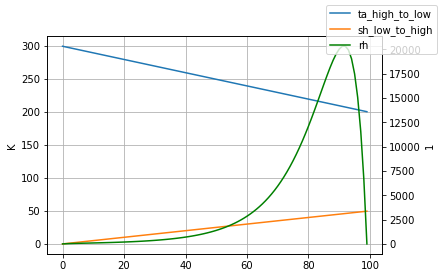

In [35]:
rh = rasotools.met.convert.to_rh(temp=ta_high_to_low, press=p_high_to_low, spec_humi=sh_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_high_to_low, label='ta_high_to_low')
ax.plot(range(0,100), sh_low_to_high, label='sh_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()

Warning relative humidiy outside of normal range
<xarray.DataArray 'rh' (time: 100)>
array([0.00000000e+00, 1.56647412e+05, 2.18253889e+05, 2.36845945e+05,
       2.34707894e+05, 2.22532551e+05, 2.05811564e+05, 1.87472102e+05,
       1.69092211e+05, 1.51508111e+05, 1.35136437e+05, 1.20153113e+05,
       1.06596009e+05, 9.44252586e+04, 8.35592509e+04, 7.38962327e+04,
       6.53272417e+04, 5.77437288e+04, 5.10418970e+04, 4.51250062e+04,
       3.99044199e+04, 3.52998832e+04, 3.12393437e+04, 2.76585114e+04,
       2.45002842e+04, 2.17141162e+04, 1.92553785e+04, 1.70847402e+04,
       1.51675874e+04, 1.34734875e+04, 1.19757021e+04, 1.06507489e+04,
       9.47800956e+03, 8.43938201e+03, 7.51897230e+03, 6.70282296e+03,
       5.97867389e+03, 5.33575243e+03, 4.76458925e+03, 4.25685698e+03,
       3.80522898e+03, 3.40325581e+03, 3.04525707e+03, 2.72622694e+03,
       2.44175142e+03, 2.18793607e+03, 1.96134276e+03, 1.75893429e+03,
       1.57802597e+03, 1.41624321e+03, 1.27148434e+03, 1.141888

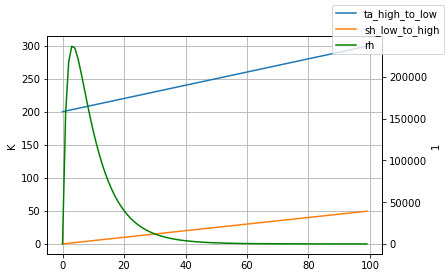

In [36]:
rh = rasotools.met.convert.to_rh(temp=ta_low_to_high, press=p_high_to_low, spec_humi=sh_low_to_high)
print (rh)
fig, ax = plt.subplots()
ax.plot(range(0,100), ta_low_to_high, label='ta_high_to_low')
ax.plot(range(0,100), sh_low_to_high, label='sh_low_to_high')
ax1 = ax.twinx()
ax1.plot(range(0,100), rh, color='green', label='rh')
ax.set_ylabel('K' )
ax1.set_ylabel('1')
ax.grid()
fig.legend()

fig.savefig("test.png")
plt.show()